# A pipeline for a histopathology image classification in Pytorch

This notebook is an example of a simple binary classification of images using CNN, implemented in PyTorch. It's purpose is to demonstrate an example of a full image analysis with the use of JupyterLab on the DNAnexus platform. The training was performed on the DNAnexus platform using JupyterLab environment but the notebook can also be run locally given a proper GPU card is available.

The data comes from a Kaggle playground competition [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection), whose aim was to identify metastatic tissue in histopathologic scans of lymph node sections.

[1. Install dependencies and setup the environment](install)  
[2. Download data from the project to the worker](#2.-Download-data-from-the-project-to-the-worker)  
[3. Inspect and preprocess input data](#3.-Inspect-and-preprocess-input-data)  
[4. Prepare input for training](#4.-Prepare-input-for-training)   
[5. Setup training](#5.-Setup-training)   
[6. Train the model](#6.-Train-the-model)  
[7. Test the model](#7.-Test-the-model)  
[8. Upload results to the project](#8.-Upload-results-to-the-project)  


<a id='install'></a>

## 1. Install dependencies and setup environment

Some of the most popular tools se need (pandas, seaborn, matplotlib, etc.) are already preinstalled in each JupyterLab instance on DNAnexus. A couple additional packages need to be installed. Making the installation a part of the notebook makes it easier to reproduce the runs later.

In [1]:
%%bash
pip install -q torch > /dev/null 2>&1
pip install -q torchvision > /dev/null 2>&1
pip install -q scikit-learn > /dev/null 2>&1
apt-get install unzip > /dev/null 2>&1

In [1]:
import copy
import datetime
import glob
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, auc
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

We set some of the global variables up front, especially those we want to experiment with and change often when tuning our model.

In [4]:
BATCH_SIZE = 256

# For first runs we only use a subset of the data
SUBSET_SIZE = 0.01

# Define how to split the training data into a train-val-test set
# (validation and test sets are divided equally from the reminder)
TRAINING_SIZE=0.9

# Set model type
MODEL_NAME = "resnet50"
if MODEL_NAME == "inception":
    MODEL_PRETRAINED = models.inception_v3(pretrained=True)
    MODEL_FOR_PREDS = models.inception_v3()
elif MODEL_NAME == "resnet50":
    MODEL_PRETRAINED = models.resnet50(pretrained=True)
    MODEL_FOR_PREDS = models.resnet50()

# Resize image size. Original size of an input image is 96x96px.
# Inception network accepts only 299x299px.
INPUT_SIZE = 96
if MODEL_NAME == 'inception':
    INPUT_SIZE = 299

# Specify if the training should be resumed from a previously saved checkpoint
RESUME_TRAINING = False
RESUME_TRAINING_PATH = 'histopathology_resnet50_subset100pct_2019-04-29-14-17-57.pth'

# Set timestamp and a path at which we will be saving model checkpoints while training
TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
CHECKPOINT_PATH = "histopathology_{model}_subset{subset}pct_{ts}.pth".format(
    model=MODEL_NAME,
    subset=int(SUBSET_SIZE * 100),
    ts=TIMESTAMP)

# How many subprocesses to use for data loading. 0 means that
# the data will be loaded in the main process
NUM_WORKERS=0

NUM_CLASSES = 2
TRAIN_LABELS = 'train_labels.csv'
TRAIN_PATH = 'normalized_train/'

## 2. Download data from the project to the worker

Input data for the notebook must be available locally or in the worker instance, in which the notebook is running. Using `dx download` we can download the data from a DNAnexus project to the local execution environment. If the notebook is running on your local computer, make sure you are logged into the DNAnexus platform before running this cell.

In [4]:
%%bash

dx download /data/train_labels.csv

echo "Downloading and unpacking normalized train data..."
dx download /data/normalized_train.tar.gz
tar -zxvf normalized_train.tar.gz > /dev/null

echo "Downloading and unpacking raw train sample..."
dx download /data/train_raw_sample.tar.gz
tar -zxvf train_raw_sample.tar.gz > /dev/null

## 3. Inspect and preprocess input data

#### Load labels

In [5]:
labels = pd.read_csv(TRAIN_LABELS, header=0, dtype={'id': str, 'label': np.int32})
labels_dict = dict(zip(list(labels.id), list(labels.label)))

#### Distribution of labels

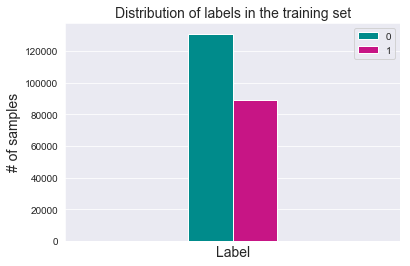

In [10]:
plt.hist([labels[labels.label == 0].label.values, labels[labels.label == 1].label.values],
         color=['darkcyan', 'mediumvioletred'], bins=1)
plt.title('Distribution of labels in the training set', fontdict = {'fontsize': 14})
plt.xlabel('Label', fontdict = {'fontsize': 14})
plt.ylabel('# of samples', fontdict = {'fontsize': 14})
plt.xticks(range(-1, 3))
plt.xticks([], [])
plt.legend(['0', '1'])
plt.show()

#### A sample of raw train data

Data (the `train.zip`, `test.zip`, `train_labels.csv` files) was downloaded from the [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data) and preprocessed (normalized, see below)outside of this notebook. Here, we first have a look at a sample of the raw train images for insights, before normalization.

A sample of images with label 0 (no tumor)


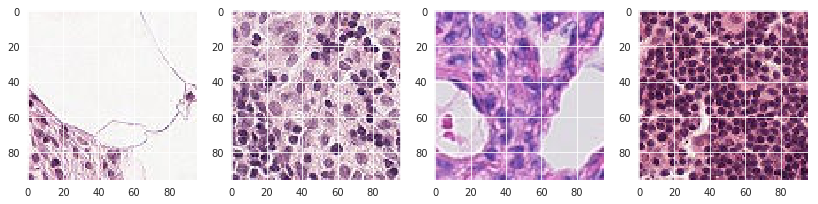

A sample of images with label 1 (tumor detected)


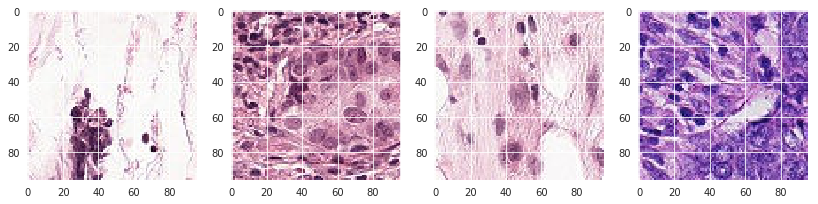

In [21]:
def show_images(sample, directory_n):
    plt.figure(figsize=(14,14))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(Image.open(directory_n + sample.iat[i, 0] + '.tif'))
    plt.show()

print("A sample of images with label 0 (no tumor)")
show_images(labels.loc[labels['label'] == 0], 'train_raw_sample/')
print("A sample of images with label 1 (tumor detected)")
show_images(labels.loc[labels['label'] == 1], 'train_raw_sample/')

This small sample shows that the microscopy images have different color, luminosity due to different staining used. We therefore ran them separately through a stain normalization tool using [StainTools](https://github.com/Peter554/StainTools).

#### Data after stain-normalization

A sample of images with label 0 (no tumor)


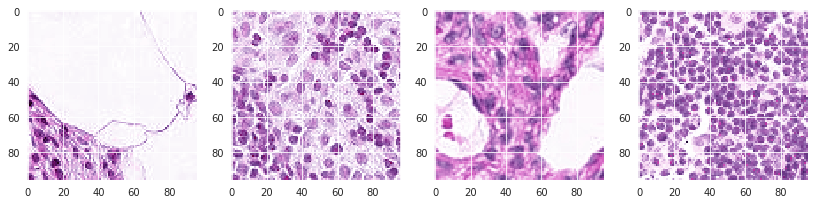

A sample of images with label 1 (tumor detected)


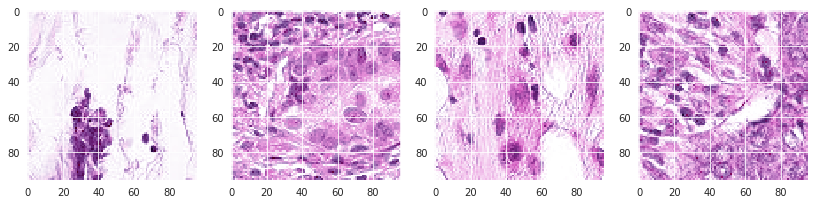

In [22]:
print("A sample of images with label 0 (no tumor)")
show_images(labels.loc[labels['label'] == 0], TRAIN_PATH)
print("A sample of images with label 1 (tumor detected)")
show_images(labels.loc[labels['label'] == 1], TRAIN_PATH)

It is a good idea to inspect the input data further here. For example, we found some a few dozen images are in fact "empty" images, i.e. they don't contain any tissue, which was a likely artifact from preparing the data.

## 4. Prepare input for training

### Split input into training, validation, test set
We will split the data into three sets: training, validation, test. Even though the class distribution in our set is close to even, we use [stratification](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) to make sure the distribution of labels is similar in each set.

In [23]:
class DataSplit():
    """
    A class for splitting data into three sets: train, validations, test.
    The training set size can be passed to split(), validation and test
    sets will be divided equally from the remaining set.
    
    Example:
    split = DataSplit(X, y, labels)
    split.split(training_size=0.9)
    split.print_splits(all_train_labels_df)
    split.create_path_sets(train_directory_path)
    """
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.X_train_paths, self.y_train = [], [], []
        self.X_val, self.X_val_paths, self.y_val  = [], [], []
        self.X_test, self.X_test_paths, self.y_test = [], [], []

    def split(self, training_size=0.8):
        random_state = np.random.RandomState(seed=42)

        # 1. Divide the full set into training and the rest
        sss_train_and_rest = StratifiedShuffleSplit(n_splits=1,
                                                    test_size=1-training_size,
                                                    random_state=random_state)
        for train_index, rest_index in sss_train_and_rest.split(self.X, self.y):
            self.X_train, X_rest = X[train_index], X[rest_index]
            self.y_train, y_rest = y[train_index], y[rest_index]

        # 2. Divide the rest equally into validation and test set
        sss_test_and_val = StratifiedShuffleSplit(n_splits=1,
                                                  test_size=0.5,
                                                  random_state=random_state)
        for val_index, test_index in sss_test_and_val.split(X_rest, y_rest):
            self.X_val, self.X_test = X_rest[val_index], X_rest[test_index]
            self.y_val, self.y_test = y_rest[val_index], y_rest[test_index]

        self.assert_no_intersections()

    def assert_no_intersections(self):
        X_train_set = set(self.X_train)
        X_val_set = set(self.X_val)
        X_test_set = set(self.X_test)
        assert(X_train_set.isdisjoint(X_val_set))
        assert(X_train_set.isdisjoint(X_test_set))
        assert(X_val_set.isdisjoint(X_test_set))
    
    def create_path_sets(self, train_dir_path):
        # Get lists of paths to inputs
        self.X_train_paths = np.array([train_dir_path + i + ".tif" for i in self.X_train])
        self.X_val_paths = np.array([train_dir_path + i + ".tif" for i in self.X_val])
        self.X_test_paths = np.array([train_dir_path + i + ".tif" for i in self.X_test])

    def get_class_distr(self, subset):
        return np.sum(subset)/len(subset)

    def print_splits(self, train_labels_df, num_classes=2):
        """
        Check that the class distribution is roughly the same across subsets.
        """
        msg_template = "We'll use {}% ({}) of the full sample size ({})"
        print(msg_template.format(int(SUBSET_SIZE * 100),
                                  int(len(train_labels_df) * SUBSET_SIZE),
                                  int(len(train_labels_df))))
        if num_classes == 2:
            print()
            print("Set    | Size   | Class distribution")
            print("------------------------------------")
            print("Full   | {:6} | {:.2f}".format(
                len(train_labels_df.label), self.get_class_distr(train_labels_df.label)))
            print("Used   | {:6} | {:.2f}".format(
                len(self.y), self.get_class_distr(self.y)))
            print("Train  | {:6} | {:.2f}".format(
                len(self.y_train), self.get_class_distr(self.y_train)))
            print("Val    | {:6} | {:.2f}".format(
                len(self.y_val), self.get_class_distr(self.y_val)))
            print("Test   | {:6} | {:.2f}".format(
                len(self.y_test), self.get_class_distr(self.y_test)))

In [24]:
train_labels_df = pd.read_csv(TRAIN_LABELS)
train_labels_subset_df = train_labels_df[:int(len(train_labels_df)*SUBSET_SIZE)]

X = train_labels_subset_df.id.values
y = train_labels_subset_df.label.values

split = DataSplit(X, y)
split.split(training_size=TRAINING_SIZE)
split.create_path_sets(TRAIN_PATH)
split.print_splits(train_labels_df, num_classes=NUM_CLASSES)

We'll use 1% (2200) of the full sample size (220025)

Set    | Size   | Class distribution
------------------------------------
Full   | 220025 | 0.41
Used   |   2200 | 0.40
Train  |   1980 | 0.40
Val    |    110 | 0.40
Test   |    110 | 0.39


### Define input data transforms with augmentation

It is important that the images have the size compatible by our model, the input is normalized, and the images are converted to PyTorch [Tensor](https://pytorch.org/docs/stable/tensors.html) objects. Aditionally, we can augment the images, i.e. make some of them randomly transformed. The normalization applied is the same of done to the pretrained models.

In [25]:
normalization_mean_std = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

data_transforms = {
    'train': transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomChoice([
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation((90, 90)),
                ]),
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation((270, 270)),
                ]),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip()
                ]),
            transforms.RandomChoice([
                transforms.ColorJitter(brightness=0.5),
                transforms.ColorJitter(contrast=0.5), 
                transforms.ColorJitter(saturation=0.5),
                transforms.ColorJitter(hue=0.5)
            ]),
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(*normalization_mean_std)
        ]),
    'val': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(*normalization_mean_std)
        ]),
}

### Setup Datasets and Dataloaders

To get a custom representation of our dataset we extend the [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) object. Dataset is then passed to [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which provides an iterator over our set and take care of batching and shuffling the data and loading it in parallel using multiprocessing workers.

In [26]:
class CancerDataset(Dataset):

    def __init__(self, num_classes, files_path, labels=None, transform=None):
        self.files = files_path
        self.transform = transform
        self.one_hot_labels = torch.eye(num_classes)[labels] if labels is not None else None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        sample_id = os.path.basename(path)[:-len(".tif")]
        image = Image.open(path)

        if self.transform:
            image = self.transform(image)

        sample = {'id': sample_id,
                  'image': image}

        if self.one_hot_labels is not None:
            sample['label'] = self.one_hot_labels[idx]

        return sample

In [27]:
datasets = {
    "train": CancerDataset(num_classes = NUM_CLASSES,
                           files_path = split.X_train_paths,
                           labels = split.y_train,
                           transform = data_transforms["train"]),
    "val": CancerDataset(num_classes = NUM_CLASSES,
                         files_path = split.X_val_paths,
                         labels = split.y_val,
                         transform = data_transforms["val"])
}

dataloaders = {set_type: DataLoader(datasets[set_type],
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)
               for set_type in ['train', 'val']}

### Test run 

Quick test of data loading and input sizes. We expect the tensor size of a batch to be `[BATCH_SIZE, 3, INPUT_SIZE, INPUT_SIZE]` and the corresponding labels' tensor size to be `[BATCH_SIZE, 2]`.

In [28]:
for i_batch, sample_batched in enumerate(dataloaders['train']):
    print(i_batch, 
          sample_batched['image'].size(),
          sample_batched['label'].size())
    if i_batch == 5:
        break

0 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
1 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
2 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
3 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
4 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
5 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])


## 5. Setup training

### Prepare helper plot functions

In [29]:
class Plot():
    
    @staticmethod
    def plot_results(losses, accuracies):
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
        ax1.plot(np.squeeze(losses['train']), 'r', label='train')
        ax1.plot(np.squeeze(losses['val']), 'g', label='val')
        ax1.set_ylabel('loss', fontsize=14)
        ax1.set_xlabel('epochs', fontsize=14)
        ax1.set_ylim(0, 1.3)
        ax1.legend()

        ax2.plot(np.squeeze(accuracies['train']), 'r', label='train')
        ax2.plot(np.squeeze(accuracies['val']), 'g', label='val')
        ax2.set_ylabel('accuracy', fontsize=14)
        ax2.set_xlabel('epochs', fontsize=14)
        ax2.set_ylim(0, 1.3)
        ax2.legend()

        plt.show()
        plt.savefig(MODEL_NAME + '_loss_and_acc.png')

    @staticmethod
    def get_auroc(y_val, pred_val, plot=False):
        fpr, tpr, _ = roc_curve(y_val, pred_val)
        auroc = auc(fpr, tpr)

        if plot:
            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',
                     lw=lw, label='ROC curve (area = %0.4f)' % auroc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")
            plt.show()
            plt.savefig(MODEL_NAME + '_auroc.png')

        return auroc

### Initialize pretrained model

We are using a pretrained model, classifyng 1000 objects. We need to reinitialize that final fully connected layer to have the same number of input features and <NUM_CLASSES> output features. In addtion to the output layer, inception models produce auxiliary layer.

We also need to send the model to GPU (by calling [cuda()](https://pytorch.org/docs/stable/notes/cuda.html) on the model). 


In [31]:
model_ft = MODEL_PRETRAINED

model_ft.fc = nn.Linear(model_ft.fc.in_features, NUM_CLASSES)
if MODEL_NAME == 'inception':
    model_ft.AuxLogits = models.inception.InceptionAux(768, num_classes)

# Freeze the first n modules
frozen = True
if frozen == True:
    child_counter = 0
    for child in model_ft.children():
        if child_counter < 6:
            print("Child {} was frozen".format(child_counter))
            for param in child.parameters():
                param.requires_grad = False
        else:
            print("Child {} was NOT frozen".format(child_counter))
        child_counter += 1

model_ft = nn.DataParallel(model_ft)
model_ft.cuda()

Child 0 was frozen
Child 1 was frozen
Child 2 was frozen
Child 3 was frozen
Child 4 was frozen
Child 5 was frozen
Child 6 was NOT frozen
Child 7 was NOT frozen
Child 8 was NOT frozen
Child 9 was NOT frozen

Parameters to learn:
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.conv3.weight
	 layer3.0.bn3.weight
	 layer3.0.bn3.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer3.1.bn2.bias
	 layer3.1.conv3.weight
	 layer3.1.bn3.weight
	 layer3.1.bn3.bias
	 layer3.2.conv1.weight
	 layer3.2.bn1.weight
	 layer3.2.bn1.bias
	 layer3.2.conv2.weight
	 layer3.2.bn2.weight
	 layer3.2.bn2.bias
	 layer3.2.conv3.weight
	 layer3.2.bn3.weight
	 layer3.2.bn3.bias
	 layer3.3.conv1.weight
	 layer3.3.bn1.weight
	 layer3.3.bn1.bias
	 layer3.3.conv2.weig

### 5.3. Define loss function and optimizer

In [32]:
criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.Adam(list(filter(lambda p: p.requires_grad, model_ft.parameters())), lr=0.0001)
scheduler = None

# Another option:
# optimizer_ft = optim.SGD(list(filter(lambda p: p.requires_grad, model_ft.parameters())), lr=0.1, momentum=0.9)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', patience=4)

### 5.4 Define training function and metrics tracking

In [33]:
def to_gpu(tensors):
    """
    Send tensors to GPU.
    """
    return tensors.pin_memory().cuda(non_blocking=True)

In [34]:
class TrainTracker(object):
    """
    A class used for printing metrics during training and validation
    """

    def __init__(self, checkpoint_path, model_state, dataloaders, num_epochs):
        self.since = time.time()
        self.best_model_wts = copy.deepcopy(model_state)
        self.dataloaders = dataloaders
        self.log = self.setup_log_file(checkpoint_path)
        self.num_epochs = num_epochs

        # best validation scores and their epochs
        self.best_acc = {'value': 0.0, 'epoch': 0}
        self.best_auroc = {'value': 0.0, 'epoch': 0}
        
        # lists of metrics, one per epoch
        self.losses = {'train': [], 'val': []}
        self.accuracies = {'train': [], 'val': []}
        
        # updated after every batch
        self.running_loss = 0.0
        self.running_corrects = 0
        
        # used only for the val phase (needed for AUROC)
        # aurocs, one per epoch
        self.val_aurocs = []
        # labels and predictions from a given epoch
        self.val_running_labels = []
        self.val_running_preds = []
        # labels and predictions that gave the best AUROC
        self.val_best_labels = []
        self.val_best_preds = []

    def setup_log_file(self, checkpoint_path):
        log_name = checkpoint_path + '.log'
        print("Log file: " + log_name)
        return open(log_name, 'a')

    def save_checkpoint(self, path, model, optimizer, epoch):
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': self.losses['train'][-1],
                    'train_auroc': self.accuracies['train'][-1],
                    'val_loss': self.losses['val'][-1],
                    'val_auroc': self.accuracies['val'][-1]
                   }, path)
        return path
        
    def init_epoch_metrics(self, phase):
        self.running_loss = 0.0
        self.running_corrects = 0
        self.val_running_labels = []
        self.val_running_preds = []

    def update_epoch_metrics(self, phase, epoch, model, optimizer):
        epoch_loss = self.running_loss / len(self.dataloaders[phase].dataset)
        epoch_acc = self.running_corrects.double() / len(self.dataloaders[phase].dataset)
        self.losses[phase].append(epoch_loss)
        self.accuracies[phase].append(epoch_acc)

        if phase == 'val':
            epoch_auroc = Plot.get_auroc(self.val_running_labels, self.val_running_preds, plot=False)
            self.val_aurocs.append(epoch_auroc)
            if epoch_auroc > self.best_auroc['value']:
                self.best_auroc = {'value': epoch_auroc, 'epoch': epoch}
                self.val_best_labels = self.val_running_labels
                self.val_best_preds = self.val_running_preds
                
                self.best_model_wts = copy.deepcopy(model.state_dict())
                self.save_checkpoint(checkpoint_path, model, optimizer, epoch)

            if epoch_acc > self.best_acc['value']:
                self.best_acc = {'value': epoch_acc, 'epoch': epoch}

    def update_running_metrics(self, phase, outputs, loss, inputs, labels, preds):
        """
        Metrics update after every batch
        """
        flat_labels = to_gpu(torch.tensor([i[1] for i in labels.data], dtype=torch.long))
        self.running_loss += loss.item() * inputs.size(0)
        self.running_corrects += torch.sum(preds == flat_labels)

        # gather the "probabilities" (scores) of the tumor present and the true labels
        if phase == 'val':
            y_probs = torch.sigmoid(outputs).detach().cpu().numpy()[:, 1]
            self.val_running_labels.extend(labels.detach().cpu().numpy()[:, 1])
            self.val_running_preds.extend(y_probs)

    def print_epoch_summary(self, epoch, epoch_starttime):
        if self.losses and self.accuracies and self.val_aurocs:
            template = 'Epoch {}/{} | Train: loss {:.4f} acc {:.4f} | Val: loss {:.4f} acc {:.4f} auroc: {:.4f} | Time: {:.2f}s'
            message = template.format(
                  epoch, self.num_epochs,
                  self.losses['train'][-1], self.accuracies['train'][-1],
                  self.losses['val'][-1], self.accuracies['val'][-1],
                  self.val_aurocs[-1],
                  time.time() - epoch_starttime)
            print(message)
            self.log.write(message + "\n")

    def print_final_summary(self):
        time_elapsed = time.time() - self.since
        mesg1 = 'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)
        mesg2 = 'Best val acc: {:4f}, epoch: {}'.format(self.best_acc['value'], self.best_acc['epoch'])
        mesg3 = 'Best val auroc: {:4f}, epoch: {}'.format(self.best_auroc['value'], self.best_auroc['epoch'])

        print(mesg1)
        print(mesg2)
        print(mesg3)

        Plot.plot_results(self.losses, self.accuracies)
        auc = Plot.get_auroc(self.val_best_labels, self.val_best_preds, plot=True)
        mesg4 = 'AUROC: {:4f}'.format(auc)
        print(mesg4)

        self.log.write(mesg1 + "\n")
        self.log.write(mesg2 + "\n")
        self.log.write(mesg3 + "\n")
        self.log.write(mesg4 + "\n")
        self.log.close()
    
    def get_best_model_weights(self):
        return self.best_model_wts

In [37]:
def train_model(model, criterion, optimizer, dataloaders, checkpoint_path,
                scheduler=None, num_epochs=25, is_inception=False):
    """
    Trains the model for the specified number of epochs and after each epoch runs a full validation
    step. It keeps track of the best performing model (in terms of validation AUROC), and at the
    end of training returns the best model.
    Inception network has two types of outputs which we need to handle, see
    https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958.
    """
    tracker = TrainTracker(checkpoint_path, model.state_dict(), dataloaders, num_epochs)

    print("Training started..")
    for epoch in range(1, num_epochs + 1):
        epoch_starttime = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            # Reset metrics before starting each phase
            tracker.init_epoch_metrics(phase)

            # Iterate over batches of data. Batch size is defined in DataLoader.
            for batch_num, sample in enumerate(dataloaders[phase]):
                inputs = to_gpu(sample['image'])
                labels = to_gpu(sample['label'])

                # Set the parameter gradients to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    # get the position of the max value of each row (argmax)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                tracker.update_running_metrics(phase, outputs, loss, inputs, labels, preds)
            tracker.update_epoch_metrics(phase, epoch, model, optimizer)
        tracker.print_epoch_summary(epoch, epoch_starttime)
    tracker.print_final_summary()
    
    # load best model weights
    model.load_state_dict(tracker.get_best_model_weights())
    return model

## 6. Train the model

If we want to continue training from a previously saved checkpoint, we will load the weights and the optimizer state here.

In [38]:
if RESUME_TRAINING:
    print("Resuming training from {}.".format(RESUME_TRAINING_PATH))
    checkpoint = torch.load(RESUME_TRAINING_PATH)
    model_ft.load_state_dict(checkpoint['model_state_dict'])
    optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])

In [39]:
model_ft_trained = train_model(model_ft, criterion, optimizer_ft, dataloaders, CHECKPOINT_PATH,
                               scheduler=scheduler, num_epochs=4, is_inception=MODEL_NAME=='inception')

Log file: histopathology_resnet50_subset1pct_2019-05-12-23-16-50.pth.log
Training started..


RuntimeError: cuda runtime error (35) : CUDA driver version is insufficient for CUDA runtime version at /pytorch/aten/src/THC/THCGeneral.cpp:51

## 7. Test the model

Define TTA transforms

In [ ]:
tta_transforms = transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5), 
        transforms.ColorJitter(saturation=0.5),
        transforms.ColorJitter(hue=0.5),
    ]),
    transforms.RandomChoice([
        transforms.RandomRotation((0,0)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.RandomRotation((90,90)),
        transforms.RandomRotation((270,270)),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((90,90)),
        ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((270,270)),
        ]),
    ]),
    data_transforms['val']])

In [137]:
def predict(test_loader, model_pred):
    model_pred.eval()
    model_pred.cuda()
    ids_all = []
    predictions = []
    for _, batch in enumerate(test_loader):
        X = batch["image"]        
        ids_all.extend(batch["id"])
        with torch.set_grad_enabled(False):
            y_pred = model_pred(X)
            # the second element of the one-hot vector contains
            # the probability the image contains a tumor
            predictions.extend(torch.sigmoid(y_pred).detach().cpu().numpy()[:, 1])
    return ids_all, predictions

def get_tta_predictions(tta_transforms, test_paths):
    # Load the test data
    test_dataset = CancerDataset(num_classes = NUM_CLASSES,
                                 files_path = test_paths,
                                 transform = tta_transforms)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)

    # Load a new model and apply the trained weights
    trained_model = MODEL_FOR_PREDS
    trained_model.fc = nn.Linear(trained_model.fc.in_features, num_classes)
    trained_model.cuda()
    trained_model = nn.DataParallel(trained_model)
    trained_model.load_state_dict(torch.load(CHECKPOINT_PATH)['model_state_dict'])

    tta_ids, tta_preds = predict(test_loader, trained_model)
    assert(len(tta_ids) == len(tta_preds))

    return tta_ids, tta_preds

## Run local test

In [139]:
# code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization



[[6 1]



 [0 4]]


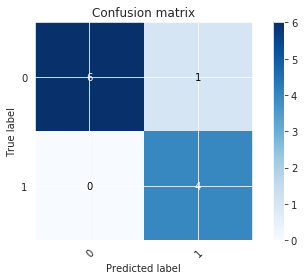

Confusion matrix, without normalization



[[6 1]



 [0 4]]


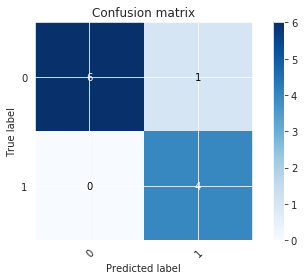

AUROC



[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Mean: 1.0000, std: 0.0000







Accuracy



[0.9091, 0.9091, 1.0, 0.9091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Mean: 0.9727, std: 0.0417


In [140]:
split_num = 10
local_test = StratifiedShuffleSplit(n_splits=split_num, test_size=0.1, random_state=random_state)

X_tests = []
y_tests = []

for _, test_index in local_test.split(X_test_paths, y_test):
    X_tests.append(X_test_paths[test_index])
    y_tests.append(y_test[test_index])

tta_preds_means = []
aurocs = []
accuracy_scores = []
i = 0
for X_part, y_part in zip(X_tests, y_tests):
    tta_ids, tta_preds = get_tta_predictions(tta_transforms, X_part)
    tta_preds_means.append(tta_preds)
    auroc_part = Plot.get_auroc(y_part, tta_preds, plot=False)
    aurocs.append(auroc_part)
    binary_preds = (tta_preds > 0.5).astype(int)    
    accuracy_scores.append(accuracy_score(y_part, binary_preds))
    if i < 2:
        plot_confusion_matrix(y_part, binary_preds, classes=[0, 1], normalize=False, title='Confusion matrix')
        plt.show()
        i+=1

print("AUROC")
print([round(i, 4) for i in aurocs])
print("Mean: {:.4f}, std: {:.4f}".format(np.mean(aurocs), np.std(aurocs)))

print()
print("Accuracy")
print([round(i, 4) for i in accuracy_scores])
print("Mean: {:.4f}, std: {:.4f}".format(np.mean(accuracy_scores), np.std(accuracy_scores)))